In [1]:
import mysql.connector, pandas as pd, numpy as np
from matplotlib import pyplot as plt
from scipy import stats, ndimage as nd
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
cnx = mysql.connector.connect(user='dbuser', password='dbpass', database='zipcode')
cursor = cnx.cursor()

In [3]:
fields = ['population',
          'employment',
          'area',
          'hunits',
          'sing_det',
          'sing_att',
          'duplex',
          'three_four',
          'five_nine',
          'ten_nineteen',
          'twenty_plus',
          '2014_later',
          '2010_2013',
          '2000_2009',
          '1990_1999',
          '1980_1989',
          '1970_1979',
          '1960_1969',
          '1950_1959',
          '1940_1949',
          '1939_older']
type_cat = ['sing_det',
          'sing_att',
          'duplex',
          'three_four',
          'five_nine',
          'ten_nineteen',
          'twenty_plus']
age_cat = ['2000_2009',
          '1990_1999',
          '1980_1989',
          '1970_1979',
          '1960_1969',
          '1950_1959',
          '1940_1949',
          '1939_older']

In [4]:
cursor.execute("SELECT {0} FROM zip_housing;".format(", ".join(fields)))
rawdata = cursor.fetchall()
df = pd.DataFrame(rawdata, columns = fields)
df = df.drop(df[df.hunits==0].index) # remove rows with zero housing units!
df['density'] = df['population']/df['area']

In [5]:
len(df)

32633

In [6]:
sum(df['hunits']), sum(df[type_cat].sum(axis=0)), sum(df[['2014_later','2010_2013'] + age_cat].sum(axis=0))

(134913539, 126319534, 134913539)

Note that the number of housing units counted in the date ranges is not the same as the number of units counted by type!

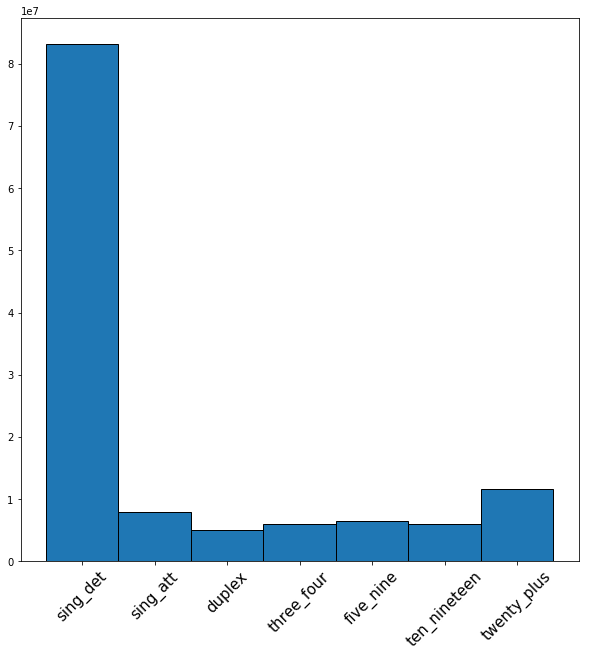

In [7]:
data = {k: v for k, v in enumerate(df[type_cat].sum(axis=0))}
ax = plt.subplot()
cnt, bins, ptc = ax.hist(list(data.keys()), weights=list(data.values()), bins=7, ec = 'black')
bin_centers = 0.5 * np.diff(bins) + bins[:-1]
ax.set_xticks(bin_centers)
ax.set_xticklabels(type_cat, rotation=45, fontsize = 15)
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.show()

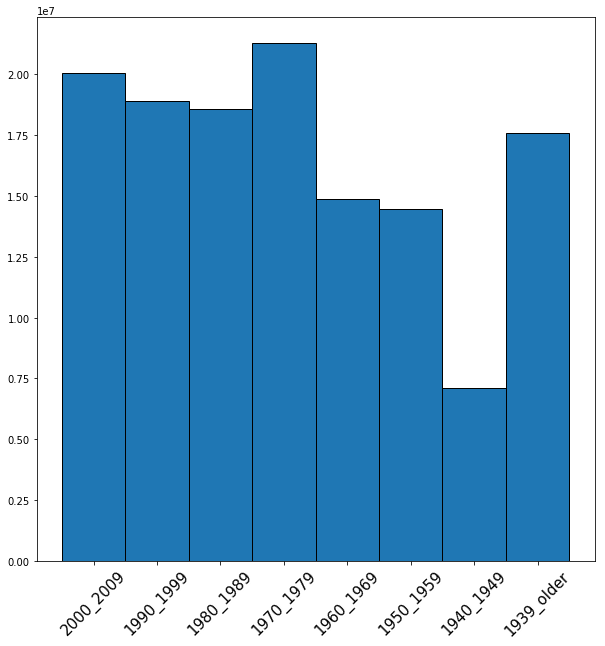

In [8]:
data = {k: v for k, v in enumerate(df[age_cat].sum(axis=0))}
ax = plt.subplot()
cnt, bins, ptc = ax.hist(list(data.keys()), weights=list(data.values()), bins=8, ec = 'black')
bin_centers = 0.5 * np.diff(bins) + bins[:-1]
ax.set_xticks(bin_centers)
ax.set_xticklabels(age_cat, rotation=45, fontsize = 15)
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.show()

In [9]:
mode_map = pd.concat([df[age_cat].idxmax(axis=1), df['density'], df['population'], df['hunits']], axis=1)
mode_map.columns = ['age_mode', 'density', 'population', 'hunits']

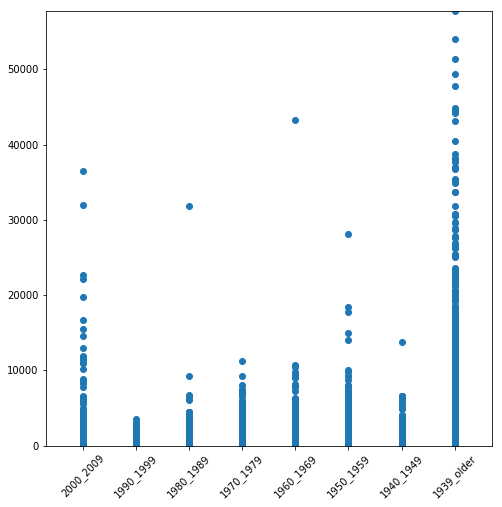

In [10]:
acmap = {name: i for i, name in enumerate(age_cat)}
ax = plt.subplot()
ax.plot([acmap[label] for label in mode_map['age_mode']], mode_map['density'], 'o')
plt.xticks(range(len(age_cat)), age_cat)
ax.margins(0.1, 0)
ax.set_xticklabels(age_cat, rotation=45)
fig = plt.gcf()
fig.set_size_inches(8,8)
plt.show()

In [11]:
def cum_dens_by_modeage(agelist):
    modes = mode_map[mode_map['age_mode'].isin(agelist)][['density', 'population']]
    modes['bin'] = pd.cut(modes['density'], [i*100 for i in rng], labels = [i for i in rng[:-1]])
    sums = [modes[modes['bin']==i]['population'].sum() for i in rng]
    cums = [sum(sums[:i]) for i in range(len(sums))]
    cums = cums / cums[-1]
    return cums

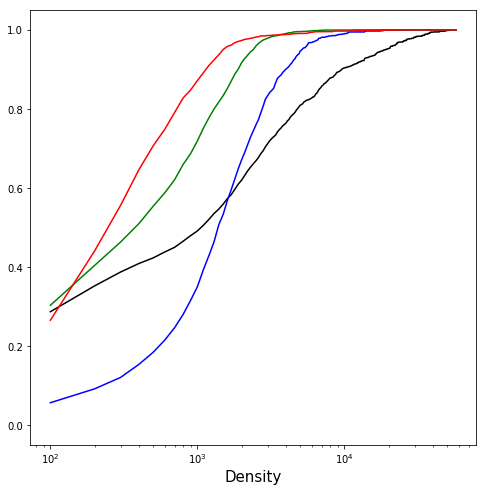

In [12]:
rng = range(0, int(max(mode_map['density'])/100))
cum_1930 = cum_dens_by_modeage(['1939_older'])
cum_lo = cum_dens_by_modeage(['1940_1949', '1950_1959', '1960_1969'])
cum_hi = cum_dens_by_modeage(['1970_1979', '1980_1989', '1990_1999'])
cum_2000 = cum_dens_by_modeage(['2000_2009'])
xs = [i*100 for i in rng]
plt.semilogx(xs, cum_1930, 'k-', xs, cum_lo, 'b-', xs, cum_hi, 'g-', xs, cum_2000, 'r-')
fig = plt.gcf()
fig.set_size_inches(8,8)
plt.xlabel("Density", fontsize = 15)
plt.show()

Pre-1940 is in black, 1940-1970 is in blue, 1970-2000 is in green, and after 2000 is in red

For comparison, the highest residential density in Washington DC is in the Adams-Morgan neighborhood at 15000 people per km$^2$. The density of Arlington from Ballston to Rosslyn metro stops is about 6000 people per km$^2$, while around George Mason it is 1500 people per km$^2$. The area around Front Royal, west of I-66 is about 100 people per km$^2$. 

In [13]:
cat_data = np.empty((7, 8))
for i, row in enumerate(type_cat):
    for j, col in enumerate(age_cat):
        cat_data[i, j] = sum(df[row]*df[col]/df['hunits'])
trutab = pd.DataFrame(cat_data, index=type_cat, columns=age_cat, dtype=int)
trutab

,2000_2009,1990_1999,1980_1989,1970_1979,1960_1969,1950_1959,1940_1949,1939_older
sing_det,13231648,12383720,11622307,13186186,8981531,8881509,4171739,9434389
sing_att,1080944,1057279,1117296,1219262,876154,868056,460750,1147528
duplex,481991,451096,493335,639427,569156,650298,396436,1294500
three_four,672204,645731,725539,887440,686525,689152,380892,1204765
five_nine,825655,819087,911708,1061701,763556,704955,345267,925055
ten_nineteen,829216,805582,907553,1026481,719441,644608,296961,730331
twenty_plus,1456613,1206455,1436357,1784572,1436910,1335572,694701,2119241


Here are the results of a $\chi^2$ test of independence

In [14]:
chi2, p, dof, exps = stats.chi2_contingency(trutab)
exptab = pd.DataFrame(exps, index=type_cat, columns=age_cat, dtype=int)
chi2, p

(2146451.9082430019, 0.0)

With a $p$ value of 0 we can, with very high confidence, reject the hull hypothesis that building type and age are independent. 

In [15]:
def color_neg_red(val):
    color = 'red' if val < 0 else 'black'
    return 'color: %s' % color

In [16]:
pct = (trutab - exptab)/exptab
pct.style.applymap(color_neg_red)

Looking at the individual building types, we can see that large apartment complexes were much more common before 1970, while single family homes were more common after. In particular, duplexes and three-four unit apartments were much more common before WWII, and much less common recently. 

In [17]:
df[type_cat].sum(axis=0)

sing_det        83240443
sing_att         7944467
duplex           5030772
three_four       5966646
five_nine        6446918
ten_nineteen     6052662
twenty_plus     11637626
dtype: int64

In [18]:
df[type_cat].sum(axis=0)/sum(df['hunits'])

sing_det        0.616991
sing_att        0.058886
duplex          0.037289
three_four      0.044226
five_nine       0.047786
ten_nineteen    0.044863
twenty_plus     0.086260
dtype: float64

In [19]:
result = smf.ols(formula = "density ~ sing_det + sing_att + duplex + three_four + five_nine + ten_nineteen + twenty_plus", data = df).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                density   R-squared:                       0.576
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     6326.
Date:                Tue, 05 Dec 2017   Prob (F-statistic):               0.00
Time:                        21:11:50   Log-Likelihood:            -2.7803e+05
No. Observations:               32633   AIC:                         5.561e+05
Df Residuals:                   32625   BIC:                         5.561e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      153.9995      8.426     18.277   

Demonstrate that `three_four` is 75% specified by the average of `duplex` and `five_nine`. 

In [20]:
result = smf.ols(formula = "three_four ~ duplex + five_nine", data = df).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             three_four   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                 5.522e+04
Date:                Tue, 05 Dec 2017   Prob (F-statistic):               0.00
Time:                        21:11:50   Log-Likelihood:            -2.2385e+05
No. Observations:               32633   AIC:                         4.477e+05
Df Residuals:                   32630   BIC:                         4.477e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8400      1.395      1.319      0.1

Plot regression where 20% of housing in a certain category is used as a feature

In [21]:
cat20 = pd.DataFrame(df['density'], columns=['density'])
for name in ['sing_att', 'duplex', 'three_four', 'five_nine', 'ten_nineteen', 'twenty_plus']:
    cat20[name] = df[name] / df['hunits'] > 0.20
result = smf.ols(formula = "density ~ sing_att + duplex + three_four + five_nine + ten_nineteen + twenty_plus", data = cat20).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                density   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     1757.
Date:                Tue, 05 Dec 2017   Prob (F-statistic):               0.00
Time:                        21:11:51   Log-Likelihood:            -2.8745e+05
No. Observations:               32633   AIC:                         5.749e+05
Df Residuals:                   32626   BIC:                         5.750e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              252.1625 

In [22]:
sum(cat20['duplex']), sum(cat20['duplex'] & cat20[['sing_att', 'three_four', 'five_nine', 'ten_nineteen', 'twenty_plus']].any(axis=1))

(396, 125)

In [23]:
sum(cat20['three_four']), sum(cat20['three_four'] & cat20[['sing_att', 'duplex', 'five_nine', 'ten_nineteen', 'twenty_plus']].any(axis=1))

(269, 138)

In [24]:
sum(cat20['five_nine']), sum(cat20['five_nine'] & cat20[['sing_att', 'three_four', 'duplex', 'ten_nineteen', 'twenty_plus']].any(axis=1))

(181, 82)

In [25]:
sum(cat20['ten_nineteen']), sum(cat20['ten_nineteen'] & cat20[['sing_att', 'three_four', 'five_nine', 'duplex', 'twenty_plus']].any(axis=1))

(179, 95)

In [26]:
sum(cat20['twenty_plus']), sum(cat20['twenty_plus'] & cat20[['sing_att', 'duplex', 'three_four', 'five_nine', 'ten_nineteen']].any(axis=1))

(1179, 184)

In [27]:
props = pd.DataFrame(df['density'], columns=['density'])
for name in ['sing_att', 'duplex', 'three_four', 'five_nine', 'ten_nineteen', 'twenty_plus']:
    props[name] = df[name] / df['hunits']
result_ols = smf.ols(formula = "density ~ sing_att + duplex + three_four + five_nine + ten_nineteen + twenty_plus", data = props).fit()
print(result_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                density   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     3139.
Date:                Tue, 05 Dec 2017   Prob (F-statistic):               0.00
Time:                        21:11:54   Log-Likelihood:            -2.8458e+05
No. Observations:               32633   AIC:                         5.692e+05
Df Residuals:                   32626   BIC:                         5.692e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -152.0674     10.724    -14.180   

In [28]:
X = props[['sing_att', 'duplex', 'three_four', 'five_nine', 'ten_nineteen', 'twenty_plus']]
X = np.concatenate([np.ones([len(df), 1]), X], axis=1)
y = np.array(props[['density']]).astype(int)

In [ ]:
X[:, 6] = np.log(X[:, 6])
result_glm = smf.GLM(y, X, family = sm.families.Gaussian()).fit()
print(result_glm.summary())

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [ ]:
predicted = result_glm.predict(X).reshape(-1, 1)
plt.plot(props['density'], result_ols.resid, 'bo', props['density'], y-predicted, 'ro', alpha = 0.2)
fig = plt.gcf()
fig.set_size_inches(10,10)

Now we do the graph in the format of 

In [ ]:
coeff, resid, rank, s = np.linalg.lstsq(X, y)
coeff, resid

In [ ]:
predicted = np.dot(X, coeff)

In [ ]:
resids = (y - predicted)
plt.plot(y, resids, 'ko')
plt.show()

In [ ]:
rowhome = trutab.loc[['sing_att']].sum()
duplex = trutab.loc[['duplex', 'three_four']].sum()
middle = trutab.loc[['five_nine', 'ten_nineteen']].sum()
rise = trutab.loc[['twenty_plus']].sum()

In [ ]:
shortab = pd.concat([rowhome, duplex, middle, rise], axis=1)
shortab.columns = ['Rowhouse', 'Duplex', 'Small Apt', 'Large Apt']
shortab = shortab.transpose().astype(int)
shortab

In [44]:
shortab.sum(axis=1)/sum(shortab.sum(axis=1))

Rowhouse     0.184243
Duplex       0.255829
Small Apt    0.289929
Large Apt    0.269998
dtype: float64

In [ ]:
cf= 0.20
tmode = pd.concat([df['sing_att']/df['hunits'] > cf, (df['duplex'] + df['three_four'])/df['hunits'] > cf, (df['five_nine'] + df['ten_nineteen'])/df['hunits'] > cf, df['twenty_plus']/df['hunits'] > cf, df['density'], df['population']], axis=1)
tmode.columns = ['rowhouse', 'duplex', 'small_apt', 'large_apt', 'density', 'population']

In [46]:
def cum_dens_by_type(typename, rng):
    modes = tmode[tmode[typename]][['density', 'population']]
    modes['bin'] = pd.cut(modes['density'], [i*100 for i in rng], labels = [i for i in rng[:-1]])
    sums = [modes[modes['bin']==i]['population'].sum() for i in rng]
    cums = [sum(sums[:i]) for i in range(len(sums))]
    return cums

In [47]:
def sum_dens_by_type(typename, rng, smoothing = 1):
    modes = tmode[tmode[typename]][['density', 'population']]
    modes['bin'] = pd.cut(modes['density'], [i*100 for i in rng], labels = [i for i in rng[:-1]])
    sums = [modes[modes['bin']==i]['population'].sum() for i in rng]
    sums = nd.gaussian_filter1d(sums, smoothing)
    return sums

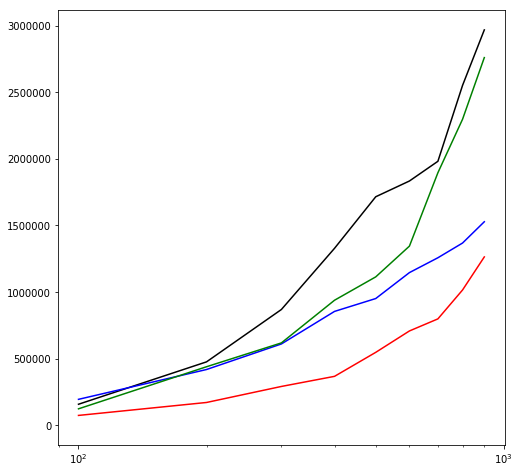

In [56]:
rng = range(0, 10)
cum_r = cum_dens_by_type('rowhouse', rng)
cum_d = cum_dens_by_type('duplex', rng)
cum_s = cum_dens_by_type('small_apt', rng)
cum_l = cum_dens_by_type('large_apt', rng)
xs = [i*100 for i in rng]
plt.semilogx(xs, cum_r, 'k-', xs, cum_d, 'b-', xs, cum_s, 'g-', xs, cum_l, 'r-')
fig = plt.gcf()
fig.set_size_inches(8,8)
plt.show()

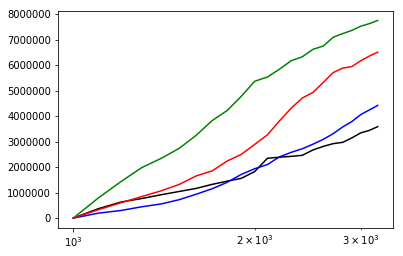

In [49]:
rng = range(10, 33)
cum_r = cum_dens_by_type('rowhouse', rng)
cum_d = cum_dens_by_type('duplex', rng)
cum_s = cum_dens_by_type('small_apt', rng)
cum_l = cum_dens_by_type('large_apt', rng)
xs = [i*100 for i in rng]
plt.semilogx(xs, cum_r, 'k-', xs, cum_d, 'b-', xs, cum_s, 'g-', xs, cum_l, 'r-')
plt.show()

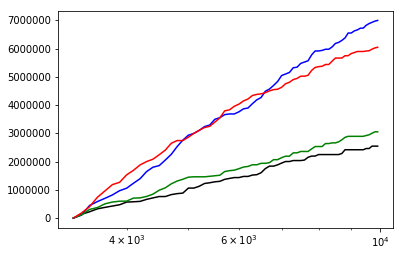

In [50]:
rng = range(33, 100)
cum_r = cum_dens_by_type('rowhouse', rng)
cum_d = cum_dens_by_type('duplex', rng)
cum_s = cum_dens_by_type('small_apt', rng)
cum_l = cum_dens_by_type('large_apt', rng)
xs = [i*100 for i in rng]
plt.semilogx(xs, cum_r, 'k-', xs, cum_d, 'b-', xs, cum_s, 'g-', xs, cum_l, 'r-')
plt.show()

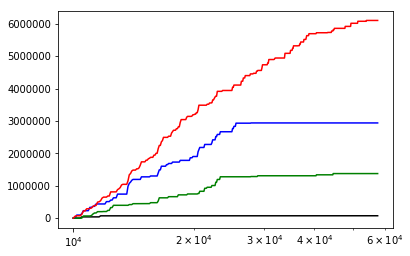

In [51]:
rng = range(100, int(max(tmode['density'])/100))
cum_r = cum_dens_by_type('rowhouse', rng)
cum_d = cum_dens_by_type('duplex', rng)
cum_s = cum_dens_by_type('small_apt', rng)
cum_l = cum_dens_by_type('large_apt', rng)
xs = [i*100 for i in rng]

plt.semilogx(xs, cum_r, 'k-', xs, cum_d, 'b-', xs, cum_s, 'g-', xs, cum_l, 'r-')
plt.show()

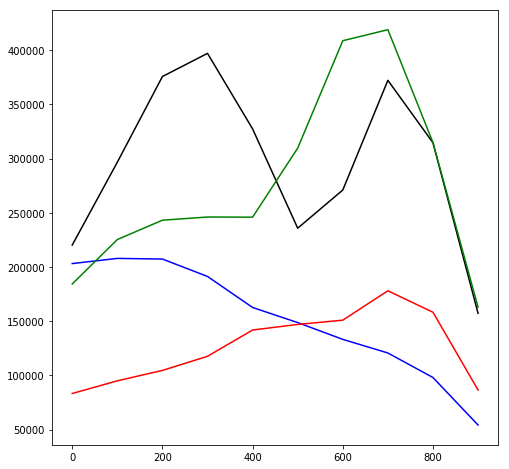

In [57]:
rng = range(0, 10)
cum_r = sum_dens_by_type('rowhouse', rng)
cum_d = sum_dens_by_type('duplex', rng)
cum_s = sum_dens_by_type('small_apt', rng)
cum_l = sum_dens_by_type('large_apt', rng)
xs = [i*100 for i in rng]

plt.plot(xs, cum_r, 'k-', xs, cum_d, 'b-', xs, cum_s, 'g-', xs, cum_l, 'r-')
fig = plt.gcf()
fig.set_size_inches(8,8)
plt.show()

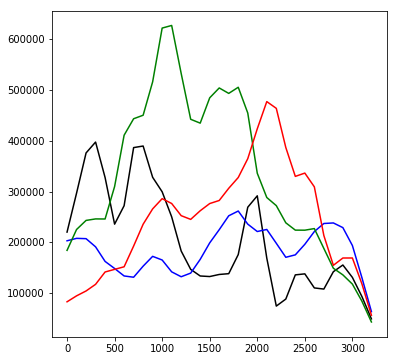

In [62]:
rng = range(0, 33)
cum_r = sum_dens_by_type('rowhouse', rng)
cum_d = sum_dens_by_type('duplex', rng)
cum_s = sum_dens_by_type('small_apt', rng)
cum_l = sum_dens_by_type('large_apt', rng)
xs = [i*100 for i in rng]

plt.plot(xs, cum_r, 'k-', xs, cum_d, 'b-', xs, cum_s, 'g-', xs, cum_l, 'r-')
fig = plt.gcf()
fig.set_size_inches(6,6)
plt.show()

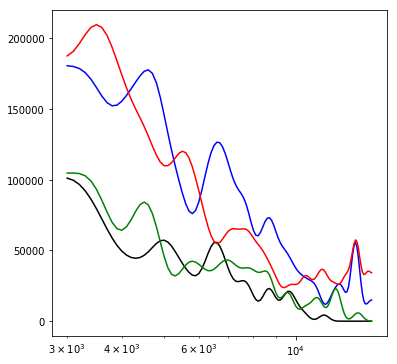

In [63]:
rng = range(30, 150)
cum_r = sum_dens_by_type('rowhouse', rng, 3)
cum_d = sum_dens_by_type('duplex', rng, 3)
cum_s = sum_dens_by_type('small_apt', rng, 3)
cum_l = sum_dens_by_type('large_apt', rng, 3)
xs = [i*100 for i in rng]

plt.semilogx(xs, cum_r, 'k-', xs, cum_d, 'b-', xs, cum_s, 'g-', xs, cum_l, 'r-')
fig = plt.gcf()
fig.set_size_inches(6,6)
plt.show()

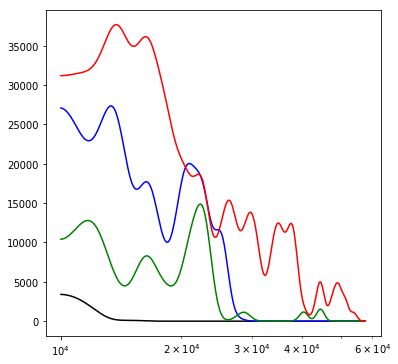

In [64]:
rng = range(100, int(max(tmode['density'])/100))
cum_r = sum_dens_by_type('rowhouse', rng, 10)
cum_d = sum_dens_by_type('duplex', rng, 10)
cum_s = sum_dens_by_type('small_apt', rng, 10)
cum_l = sum_dens_by_type('large_apt', rng, 10)
xs = [i*100 for i in rng]

plt.semilogx(xs, cum_r, 'k-', xs, cum_d, 'b-', xs, cum_s, 'g-', xs, cum_l, 'r-')
fig = plt.gcf()
fig.set_size_inches(6,6)
plt.show()